# ScanAI - Model Training Notebook (MNIST + EMNIST)

## 1. Import Required Libraries

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## 2. Load and Prepare the Datasets

In [19]:
# Load MNIST dataset (digits)
mnist = tf.keras.datasets.mnist
(train_images_mnist, train_labels_mnist), (test_images_mnist, test_labels_mnist) = mnist.load_data()

# Load EMNIST dataset (letters)
# Note: EMNIST is not included in TensorFlow by default, so we use the `emnist` package.
# Install it using: pip install emnist
from emnist import extract_training_samples, extract_test_samples

train_images_emnist, train_labels_emnist = extract_training_samples('letters')
test_images_emnist, test_labels_emnist = extract_test_samples('letters')

# Normalize pixel values to [0, 1]
train_images_mnist = train_images_mnist / 255.0
test_images_mnist = test_images_mnist / 255.0
train_images_emnist = train_images_emnist / 255.0
test_images_emnist = test_images_emnist / 255.0

# Reshape images to include a single channel (grayscale)
train_images_mnist = train_images_mnist.reshape(-1, 28, 28, 1)
test_images_mnist = test_images_mnist.reshape(-1, 28, 28, 1)
train_images_emnist = train_images_emnist.reshape(-1, 28, 28, 1)
test_images_emnist = test_images_emnist.reshape(-1, 28, 28, 1)

# Make the labels writable by creating a copy
train_labels_emnist = train_labels_emnist.copy()
test_labels_emnist = test_labels_emnist.copy()

# Adjust EMNIST labels (EMNIST letters are labeled from 1 to 26, so subtract 1 to make them 0-25)
train_labels_emnist -= 1
test_labels_emnist -= 1

# Combine MNIST and EMNIST datasets
train_images = np.concatenate([train_images_mnist, train_images_emnist])
train_labels = np.concatenate([train_labels_mnist, train_labels_emnist + 10])  # Shift EMNIST labels to 10-35
test_images = np.concatenate([test_images_mnist, test_images_emnist])
test_labels = np.concatenate([test_labels_mnist, test_labels_emnist + 10])

# Print dataset shapes
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (184800, 28, 28, 1)
Training labels shape: (184800,)
Test images shape: (30800, 28, 28, 1)
Test labels shape: (30800,)


## 3. Data Augmentation

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(train_images)

## 4. Build the CNN Model

In [21]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(36, activation='softmax')  # 10 digits + 26 letters
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,388 (892.14 KB)

 Trainable params: 228,388 (892.14 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the Model

In [22]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    epochs=50,
                    validation_data=(test_images, test_labels))

Epoch 1/50
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.6994 - loss: 1.0244 - val_accuracy: 0.8835 - val_loss: 0.3573
Epoch 2/50
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.8957 - loss: 0.3232 - val_accuracy: 0.8751 - val_loss: 0.4036
Epoch 3/50
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9169 - loss: 0.2543 - val_accuracy: 0.8822 - val_loss: 0.3969
Epoch 4/50
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9252 - loss: 0.2284 - val_accuracy: 0.8864 - val_loss: 0.3889
Epoch 5/50
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.9315 - loss: 0.2065 - val_accuracy: 0.8899 - val_loss: 0.3750
Epoch 6/50
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9366 - loss: 0.1910 - val_accuracy: 0.9012 - val_loss: 0.3245
Epoch 7/50
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.9387 - loss: 0.1818 - val_accuracy: 0.8942 - val_loss: 0.3878
Epoch 8/50
5775/5775 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.9413 - lo

## 6. Evaluate the Model

In [23]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

963/963 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9626 - loss: 0.1530
Test Accuracy: 93.89%


## 7. Visualize Training Results

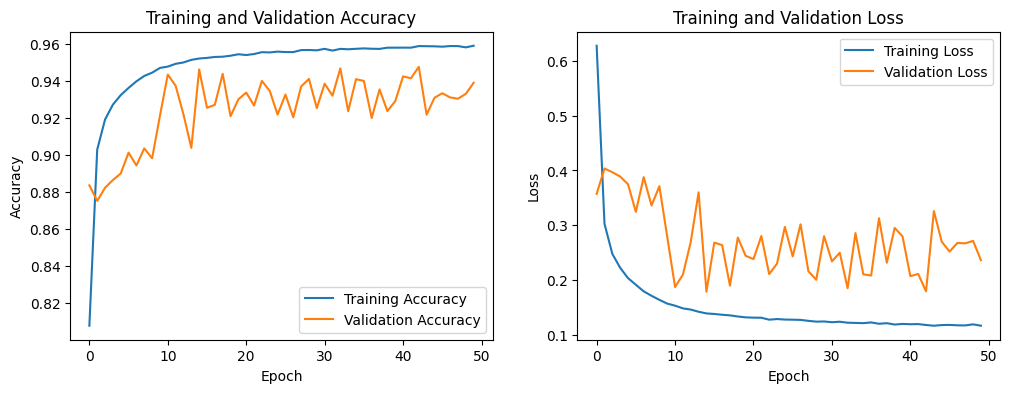

In [24]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 8. Save the Model

In [25]:
model.save('handwritten_char_model.h5')
print("Model saved as 'handwritten_char_model.h5'")

Model saved as 'handwritten_char_model.h5'


## 9. Test the Model on Custom Images

In [26]:
def preprocess_image(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (28, 28))
    image = image.reshape(1, 28, 28, 1) / 255.0
    return image

def predict_image(image_path):
    # Preprocess and predict
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    return np.argmax(prediction)

# Test on a sample image
image_path = 'images/A.jpg'
predicted_class = predict_image(image_path)

# Map predicted class to label
if predicted_class < 10:
    print(f"Predicted Digit: {predicted_class}")
else:
    print(f"Predicted Letter: {chr(ord('A') + predicted_class - 10)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Letter: N


## 10. Conclusion

- The model achieves high accuracy on the combined MNIST and EMNIST dataset.
- The saved model (`handwritten_char_model.h5`) can be integrated into the Flask backend for real-time predictions.
- The model can recognize both digits (0-9) and letters (A-Z).